# Question 1

In this question we will:

- Design and implement a feature that can be used to creates a feature map sensitive to "greenness".
- Utilize thresholding techniques of this "greenness" feature to obtain a segmentation of green leaves in images with a cluttered background.
- Implement evaluation metrics to measure the quality of a segmentation produced by the thresholding
- Use the metrics to evaluate the segmentation algoirthm's perormance on a dataset of images of green leaves on a cluttered background.

# Step 1: Write your Segmentation Algoirthm

Write a function that segments a leaf image, and returns a binary (`dtype='bool'`) image representing the segmentation.  Your algorithm must be based on thresholding.  Determine a metric that can be used to meaure the "greenness" of the colour of a given pixel.  Your algoirthm should create a "feature map" by computing this feature for each pixel, thus creating an "image" where each pixel's "intensity" is the value of the "greenness" feature.   Then use a thresholding method of your choice to segment the image's green regions.    You should also consider whether doing some region processing after segmentation can improve the results.  This function should return the segmenetion of the image as a binary image with a single connected component since you can take advantage of the fact that each image is known to contain only a single leaf.

_Hint: You'll need to be a bit creative when devising your solution -- no single technique from class is likely to give you a particularly good solution, and you may need to think of some tricks that were not explicitly covered in class.  However, you can get a bad result with a fairly simple algorithm.  You'll also need to decide how to handle the fact that the input images are colour, although this shouldn't pose too much of a problem, in fact, it is an advantage!_

In [1]:
import skimage.util as util
import skimage.io as io
import numpy as np
import os as os
import matplotlib.pyplot as plt
import skimage.morphology as morph
import skimage.filters as filt
from skimage.measure import label, regionprops

# You can import other modules as needed.

def segleaf(I):
    '''
    Segment a leaf image.
    :param I: Color leaf image to segment.
    :return: Logical image where True pixels represent foreground (i.e. leaf pixels).
    '''

    # convert to float
    I = util.img_as_float(I)

    I = filt.gaussian(I, sigma=0.5)

    # determine a metric that can be used to measure the "greenness" of the colour of a given pixel:
    segmented = np.where(True, I[:,:,1] / (I[:,:,0] + I[:,:,1] + I[:,:,2] + 0.00001), 0)

    thresh = filt.threshold_otsu(segmented)
    binary = segmented > thresh

    binary = largest_region(binary)

    binary = filt.median(binary, morph.footprint_rectangle([7,7]))
    binary = morph.remove_small_objects(binary, min_size=5000)

    return binary


def largest_region(segmented_image):
    labeled = label(segmented_image)
    properties = regionprops(labeled)
    largest = max(properties, key=lambda p: p.area)
    
    return (labeled == largest.label) 


# image_path = os.path.join('.', 'images', 'image_0002.png')
# img = io.imread(image_path)
# grn = segleaf(img)
# print(grn.dtype)

# plt.imshow(grn, cmap='gray', vmin=0, vmax=1)
# plt.show()

# Step 2: Implement Segmentation Performace Measures

Write functions to compute the Mean Squared Distance (MSD), Hausdorff Distance (HD) and Dice Similarity Coefficient (DSC) measures of segmentation quality.  

For MSD and HD, I suggest you reprsent boundaries by N-row, 2-column arrays where each row is the coordinate of one pixel on the region's boundary of the form [r,c], row first, then column.

In [2]:
import skimage.segmentation as seg


def mean_squared_distance(B, G):
    B = boundary_pixels(B)
    G = boundary_pixels(G)

    min_distances = []
    for b in B:
        min_distances.append(np.min(dist(b, G)))

    return np.sum(min_distances) / len(min_distances)    


def hausdorff_distance(B, G):
    B = boundary_pixels(B)
    G = boundary_pixels(G)

    min_b_distances = []
    for b in B:
        min_b_distances.append(np.min(dist(b, G)))
    max_b = max(min_b_distances)

    min_g_distances = []
    for g in G:
        min_g_distances.append(np.min(dist(g, B)))
    max_g = max(min_g_distances)

    return max(max_b, max_g)


def dice_similarity_coefficient(B, G):
    B = np.argwhere(B)
    G = np.argwhere(G)

    # find the intersection of boundary pixels in B and G
    B_tuples = tuple_set(B)
    G_tuples = tuple_set(G)
    intersection = B_tuples.intersection(G_tuples)

    # sum the cardinality of B and G
    summed_cardinality = B.shape[0] + G.shape[0]

    return 2*len(intersection)/summed_cardinality


def boundary_pixels(label_image):
    # code taken from topic 6 slide 68
    bp = np.where(seg.find_boundaries(label_image > 0, connectivity=2, mode='inner') > 0)
    return np.transpose(np.vstack(bp))


def dist(a, B):
    return np.sqrt(np.sum((B - a) ** 2, axis=1))


# Takes a 2-d array and returns a set of tuples along the first dimension
def tuple_set(array):
    return set(tuple(i) for i in array)


# b_path = os.path.join('.', 'images', "image_0002.png")
# g_path = os.path.join('.', 'groundtruth', "image_0002.png")
# img = io.imread(b_path)
# B = segleaf(img)
# # b_bounds = boundary_pixels(B)
# b_labels = morph.label(B, connectivity=2)

# plt.imshow(seg.mark_boundaries(B, b_labels, color=(0,1,1)))
# plt.show()

# G = io.imread(g_path)
# g_labels = morph.label(G, connectivity=2)
# plt.imshow(seg.mark_boundaries(G, g_labels, color=(0,1,1)))
# plt.show()

# msd = mean_squared_distance(B, G)
# print(f"msd: {msd}")

# hd = hausdorff_distance(B, G)
# print(f"hd: {hd}")

# dsc = dice_similarity_coefficient(B, G)
# print(f"dsc: {dsc}")



# Step 3: Write a Validation driver program.

Write code that segments each image (using the function in Step 1), and computes the MSD, HD, and DSC for each segmentation (using the functions in Step 2).  Print the MSD, HD, and DSC of each segmentation to the console as you perform it.  At the end, print the average and standard deviation of the DSC, the MSD, and the HD over all of the images.  Also print the percentage of regions that were "recognized" (see below).  Sample output is in the assignment description document.

The general approach should be, for each input image:

* load the image and it's ground truth (use the provided leaf image dataset, described in section 2.2. of the assignment PDF) -- a .csv file is provided with the names of all images so that you can process the files in the same manner as Assignment 1, question 1)
* segment the input image using your function from Step 1
* extract the region boundary points from the segmented image and ground truth image; store them in Nx2 arrays as described above (see lecture notes Topic 6, slide 68 for an example on how to do this).
* Compute the MSD and the HD from the two sets of boundary points (using the appropriate functions in Step 2).
* Compute the DSC from the segmented image and the ground truth image (using the appropriate function from Step 2).
* Determine whether the leaf was "recognized" (a leaf is recognized if it's DSC is greater than 0.6).
* Print the MSD, HD, and DSC to the console (see sample output).

When finished processing each image, don't forget to print the average and standard deviation of the DSC for all images, and the percentage of images where the leaf was "recognized".

_Feel free to define additional helper functions for your program if you think it will help._

In [3]:
#### Validate ####
import pandas as pd

# Paths for folders -- original and ground truth images
images_path = os.path.join('.', 'images')
gt_path = os.path.join('.', 'groundtruth')

# TODO Change the I/O to use a CSV file like in assignment 0.
csv = pd.read_csv("images.csv", header=None)
file_list = csv[0].tolist()

dsc_list = []
msd_list = []
hd_list = []
recognized = 0

for filename in file_list:
        b_path = os.path.join(images_path, filename)
        g_path = os.path.join(gt_path, filename)
        img = io.imread(b_path)
        B = segleaf(img)
        G = io.imread(g_path)

        dsc = dice_similarity_coefficient(B, G)
        msd = mean_squared_distance(B, G)
        hd = hausdorff_distance(B, G)
        
        dsc_list.append(dsc)
        msd_list.append(msd)
        hd_list.append(hd)

        if dsc >= 0.8: recognized += 1

        print(f"DSC for {filename} : {dsc}")
        print(f"MSD for {filename} : {msd}")
        print(f"HD for {filename} : {hd}")
        print("--------------------------------------------------")

mean_dsc = np.mean(dsc_list)
sd_dsc = np.std(dsc_list)
mean_msd = np.mean(msd_list)
sd_msd = np.std(msd_list)
mean_hd = np.mean(hd_list)
sd_hd = np.std(hd_list)
recognized_pct = round(recognized/len(file_list) * 100) 

print(f"The mean Dice coefficient was: {mean_dsc}")
print(f"The std. deviation of Dice coefficient was: {sd_dsc}")
print(f"The mean MSD was: {mean_msd}")
print(f"The std. deviation of MSD was:{sd_msd}")
print(f"The mean HD was: {mean_hd}")
print(f"The std. deviation of HD was: {sd_hd}")
print(f"{recognized_pct}% of leaves were recognized.")

DSC for image_0001.png : 0.9949762065720231
MSD for image_0001.png : 0.4912977668890046
HD for image_0001.png : 28.442925306655784
--------------------------------------------------
DSC for image_0002.png : 0.9918831278728921
MSD for image_0002.png : 0.2565884662245771
HD for image_0002.png : 105.92922165295089
--------------------------------------------------
DSC for image_0005.png : 0.9943918596250627
MSD for image_0005.png : 0.5571811579859379
HD for image_0005.png : 30.265491900843113
--------------------------------------------------
DSC for image_0007.png : 0.9954724098142692
MSD for image_0007.png : 0.39360043949575363
HD for image_0007.png : 21.470910553583888
--------------------------------------------------
DSC for image_0009.png : 0.9946934412460869
MSD for image_0009.png : 0.9966850724680523
HD for image_0009.png : 30.805843601498726
--------------------------------------------------
DSC for image_0010.png : 0.9958320091915809
MSD for image_0010.png : 0.2068970504891733
H

# Step 4:  Display Examples

Choose one input image where your algoirthm performed very well.  Choose another image where the algorithm did not perform well.  Display the two original images with the segmentation superimposed on top (There is an example in the lecture notes -- last slide, Topic 6 -- showing how to do this).  Also display the same two image's ground truth with the segmentation superimposed on top.    Title the images to indicate which is the "bad" example, and which is the "bad" example.


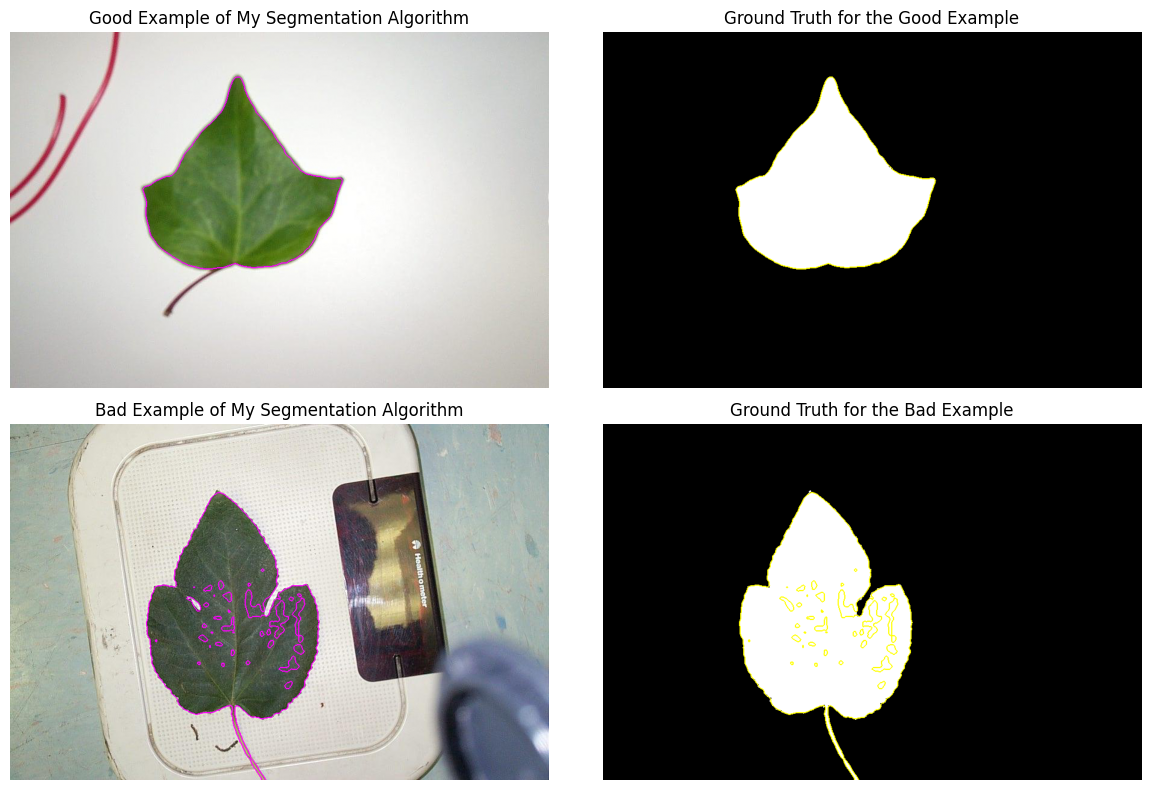

In [17]:
import matplotlib.pyplot as plt

%matplotlib inline

# Good = image_0165.png
good_path = os.path.join('.', 'images', 'image_0165.png')
good_img = io.imread(good_path)
good_segmented = segleaf(good_img)
good_labels = morph.label(good_segmented, connectivity=2)
good_superimposed = seg.mark_boundaries(good_img, good_labels, color=(1, 0, 1), mode='thick')

# Good ground truth
good_gt_path = os.path.join('.', 'groundtruth', 'image_0165.png')
good_gt = io.imread(good_gt_path)
good_gt_superimposed = seg.mark_boundaries(good_gt, good_labels, color=(1, 1, 0), mode='thick')

# Bad = image_0099.png
bad_path = os.path.join('.', 'images', 'image_0099.png')
bad_img = io.imread(bad_path)
bad_segmented = segleaf(bad_img)
bad_labels = morph.label(bad_segmented, connectivity=2)
bad_superimposed = seg.mark_boundaries(bad_img, bad_labels, color=(1, 0, 1), mode='thick')

# Bad ground truth
bad_gt_path = os.path.join('.', 'groundtruth', 'image_0099.png')
bad_gt = io.imread(bad_gt_path)
bad_gt_superimposed = seg.mark_boundaries(bad_gt, bad_labels, color=(1, 1, 0), mode='thick')

plt.subplots(2, 2, figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.imshow(good_superimposed)
plt.axis('off')
plt.title("Good Example of My Segmentation Algorithm")

plt.subplot(2, 2, 2)
plt.imshow(good_gt_superimposed)
plt.axis('off')
plt.title("Ground Truth for the Good Example")

plt.subplot(2, 2, 3)
plt.imshow(bad_superimposed)
plt.axis('off')
plt.title("Bad Example of My Segmentation Algorithm")

plt.subplot(2, 2, 4)
plt.imshow(bad_gt_superimposed)
plt.axis('off')
plt.title("Ground Truth for the Bad Example")

plt.tight_layout()

# Step 5: A time for reflection.

### Answer the following questions right here in this block.

1. In a few sentences, briefly explain what your segmentation algorithm from Step 1 does and how it works.  

	_Your answer:_  First, I apply some gaussian filtering with sigma=0.5 to clean up the noise in the images. Next, I create a feature map by dividing the intensity of the green channel of the image by the combined intensity of all three channels. I apply otsu thresholding to the feature map. I label each region in the image and take only the largest one (which I assume should always be the leaf). I apply median filtering with a 7x7 kernel size to smooth out some of the small imperfections, and I use remove_small_objects with a relatively large minimum size to remove anything that the median filtering doesn't catch.

2. Consider your example "good" result.  What, if anything, about your algoirthm is preventing you from getting a better result with this image?  If you weren't able to get any results, leave this blank, or explain what was preventing you from getting a result.

	_Your answer:_  This one is almost perfect, I think the one thing that could have made my result closer to the provided ground truth would be to apply less aggressive median filtering to retain the somewhat "jagged" edges in the ground truth image.

3. Consider your example "bad" result.  What is it about your algoirthm caused the poor performance?   If you weren't able to get any results, leave this blank.

	_Your answer:_  I couldnt figure out why the median filtering and the remove_small_objects() were not getting rid of the small black spots inside the leaf. I guess I may have been able to fix it if I used some erosion or the remove_small_objects() function.
